In [41]:
import numpy as np
import pandas as pd
import random

from trmf import trmf
from Forecast import AutoRegressionModel, NaiveModel, MeanModel
from RollingCV import RollingCV, get_slice

from Metrics import ND, NRMSE

import matplotlib.pyplot as plt
%matplotlib inline

# Experiments on missing data imputation

#### 1. Experiment description:

** Models: ** Naive, Mean and TRMF models;

** Missing Percent: ** 5%, 10%, 25%; 

** Lags: ** {1, 24};

** Metrics: ** Normalized deviation (ND), Normalized Root Mean Squared Error (NRMSE).

##### 2. Load data.

In [2]:
electricity = pd.read_table('LD2011_2014.txt', sep=';', decimal=',')

In [40]:
# transpose and sum by hours
data = electricity.values[:,1:].T.reshape((35064*370,4)).sum(axis=1).reshape((370,35064))[:,10064:].astype(float)[:, -750:]
data.shape

(370, 750)

In [42]:
# Normalize
data, _ = get_slice(data, 750, 0, 0, normalize=True)

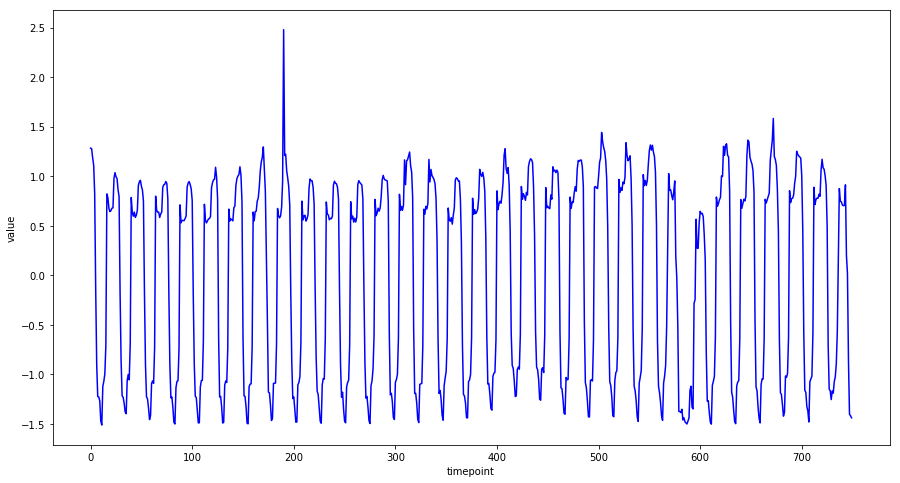

In [43]:
plt.figure(figsize=(15,8))
plt.plot(data[100], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [44]:
N = 370
T = 750
K = 8
lags = [1, 24]
L = len(lags)

##### 3. Apply models

In [45]:
# Naive model
scores_nd = []
scores_nrmse = []

for mp in [0.05, 0.1, 0.25]:
    for _ in range(10):
        mask = (np.random.random(data.shape) > mp).astype(int)
        data_missing = data.copy()
        data_missing[mask == 0] = np.nan
        model = NaiveModel()
        model.fit(data_missing)
        data_imputed = model.impute_missings()
        scores_nd.append(ND(data[mask==0], data_imputed[mask==0]))
        scores_nrmse.append(NRMSE(data[mask==0], data_imputed[mask==0]))    
    print('Naive model performance ND/NRMSE (mp={}): {}/{}'.format(mp, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3)))

Naive model performance ND/NRMSE (mp=0.05): 0.367/0.574
Naive model performance ND/NRMSE (mp=0.1): 0.373/0.584
Naive model performance ND/NRMSE (mp=0.25): 0.391/0.613


In [50]:
# Mean model
scores_nd = []
scores_nrmse = []

for mp in [0.05, 0.1, 0.25]:
    for _ in range(10):
        mask = (np.random.random(data.shape) > mp).astype(int)
        data_missing = data.copy()
        data_missing[mask == 0] = np.nan
        model = MeanModel()
        model.fit(data_missing)
        data_imputed = model.impute_missings()
        scores_nd.append(ND(data[mask==0], data_imputed[mask==0]))
        scores_nrmse.append(NRMSE(data[mask==0], data_imputed[mask==0]))    
    print('Mean model performance ND/NRMSE (mp={}): {}/{}'.format(mp, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3)))

Mean model performance ND/NRMSE (mp=0.05): 129.506/150.367
Mean model performance ND/NRMSE (mp=0.1): 108.291/125.712
Mean model performance ND/NRMSE (mp=0.25): 89.242/103.586


In [49]:
# TRMF model
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 5000


# Mean model
scores_nd = []
scores_nrmse = []

for mp in [0.05, 0.1, 0.25]:
    for _ in range(10):
        mask = (np.random.random(data.shape) > mp).astype(int)
        data_missing = data.copy()
        data_missing[mask == 0] = np.nan
        model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
        model.fit(data_missing)
        data_imputed = model.impute_missings()
        scores_nd.append(ND(data[mask==0], data_imputed[mask==0]))
        scores_nrmse.append(NRMSE(data[mask==0], data_imputed[mask==0]))    
    print('TRMF model performance ND/NRMSE (mp={}): {}/{}'.format(mp, round(np.array(scores_nd).mean(),3),\
                                                                   round(np.array(scores_nrmse).mean(),3)))

TRMF model performance ND/NRMSE (mp=0.05): 0.359/0.516
TRMF model performance ND/NRMSE (mp=0.1): 0.36/0.519
TRMF model performance ND/NRMSE (mp=0.25): 0.361/0.52


### Results Missing Data Imputation (ND/NRMSE) [mp = missing percent]

| | mp=5% | mp=10% | mp=25% ||
|------|------|------|
| Naive | 0.367/0.574 | 0.373/0.584 | 0.391/0.613 |
| Mean | 129.506/150.367 | 108.291/125.712 | 89.242/103.586 |
| TRMF | **0.359/0.516** | **0.36/0.519** | **0.361/0.52** |
